In [2]:
import numpy as np
import pickle as pk
import pandas as pd

from PIL import Image, ImageDraw

import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

norm = matplotlib.colors.Normalize(vmin=1, vmax=3)
cmap = matplotlib.cm.get_cmap('viridis')

root = r"C:\tmp\OwnCloud\docs\neuroconnlab\dist_model\git\\"

# plotting functions

In [9]:
from brainspace.utils.parcellation  import map_to_labels, reduce_by_labels
from lib.plotting import infer_colorbar,  paste_centrally, fig2tightPIL
import hcp_utils as hcp
from surfplot import Plot
from neuromaps.datasets import fetch_fslr
import numpy as np
from matplotlib.lines import Line2D


surfaces = fetch_fslr()
lh, rh = surfaces['inflated']

from brainspace.datasets  import load_parcellation



def show_pdata(data, ld = None, is_32k=False, cmap="coolwarm", mw_val=0, outline=None, title=None, outline_cmap = "Reds", plot_kwargs = {}, **kwargs):
  out = data if ld is None else map_to_labels(data, ld, mask=ld!=mw_val, fill=0)
  lcd = hcp.left_cortex_data(out) if not is_32k else out;
  pkw = dict(surf_lh=lh, size=(800, 300), zoom=1.7)
  pkw.update(plot_kwargs)
  p = Plot(**pkw)
  lkw = dict(cmap=cmap, cbar=True);
  lkw.update(kwargs)
  p.add_layer({'left': lcd},  **lkw)
  if not(outline is None):
    out2 = outline if ld is None else map_to_labels(outline, ld, mask=ld!=mw_val, fill=0)
    ocd = hcp.left_cortex_data(out2) if not is_32k else out2;
    p.add_layer({'left': ocd}, cmap=outline_cmap, as_outline=True, cbar=False)
  fig = p.build()
  if not(title is None): fig.axes[0].set_title(title)
  #fig.show()
  return fig


import io, PIL
def fig2pil(fig, pad_inches=-0.0, close=False):
  buf = io.BytesIO()
  fig.savefig(buf, bbox_inches="tight", pad_inches=pad_inches);
  buf.seek(0)
  ret = PIL.Image.open(buf);
  if close: plt.close(fig)
  return ret

def add_cbar(xx, data, uc=0.8, lc=0,cmap="viridis", **kwargs):
  jargs = dict(cmap=cmap, aspect=12, shrink=0.18)
  jargs.update(kwargs)
  cb = infer_colorbar(data, **jargs);
  cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=100, format="png", close_fig=1)
  return img2

In [13]:
def subplot_grid(n_rows, n_cols, cw=7, rh="auto", axis_off=True, flat_axes=False, **kwargs):
  if rh=="auto": rh = cw *0.428;
  fig_args = dict(figsize=((n_cols)*cw, rh*n_rows))
  fig_args.update(kwargs)
  fig, axs = plt.subplots(n_rows,n_cols, **fig_args)
  faxs = axs.flatten()
  if axis_off:
    for i in range(len(faxs)): faxs[i].axis("off");
  return fig, (faxs if flat_axes else axs);

from PIL import Image, ImageDraw 
def image_grid(imgs, rows, cols, size=None, pad=0.01):
    assert len(imgs) <= rows*cols
    imgw, imgh = imgs[0].size if size is None else size
    pw,ph = int(imgw*pad), int(imgh*pad);
    w, h = imgw+pw, imgh+ph;

    grid = PIL.Image.new('RGBA', size=(cols*(w), rows*(h)))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        ew, eh = imgw-img.size[0], 2*(imgh-img.size[1]) # 2* to align at bottom
        #print(w,h,ew,eh)
        #grid.paste(img, box=(i%cols*w, i//cols*h))
        #print((i%cols*w)+0.5*(pw+ew))
        grid.paste(img, box=((i%cols*w)+int(0.5*(pw+ew)), (i//cols*h)+int(0.5*(ph+eh))))
    return grid


def add_patches(ax, cmap="viridis", titles=["real", "predicted", "overlap"], mm=(1,3), **kwargs):
  leg_kwargs = dict(loc='lower center')
  leg_kwargs.update(kwargs)
  cmap = cm.get_cmap(cmap)
  norm = mplcolors.Normalize(vmin=mm[0], vmax=mm[1])
  patches = []
  for i, label in enumerate(titles):
    patches.append(mpatches.Patch(color=cmap(norm(i+1)), label=label))
    ax.legend(handles=patches, **leg_kwargs)

In [14]:
percentile = 90
dice_fn = lambda ground_truth, prediction : np.sum(prediction[ground_truth==1])*2.0 / (np.sum(prediction) + np.sum(ground_truth))

def threshold_map(brain_map, percentile, binary = False, binary_val = 1):
  
  threshold = np.percentile(brain_map, percentile)
  mask = brain_map >= threshold;
  #if binary: return mask;
  brainmap_thres = np.zeros_like(brain_map)
  brainmap_thres[mask] = binary_val if binary else brain_map[mask] 
  return brainmap_thres;


# load the nessesary data and info

In [15]:
# get the scores from the regression result data 

regr_data = np.load("results/scores/linear_regression_scores_and_info_v3.yfull.aa.extended.small.npy", allow_pickle=1).item()
print(regr_data.keys(), "\n", regr_data['RS-PCA200'].keys())
subjs = regr_data["RS-PCA200"]["sub_test"]

regr_data_sm = np.load("results/scores/linear_regression_scores_and_info_v3.yfull.aa.npy", allow_pickle=1).item()
print(regr_data_sm.keys(), "\n", regr_data_sm['RS-PCA200'].keys())

cdict = {k: v["scoresd"] for k,v in regr_data_sm.items()}
ddict = {k: v["diff_scores_test"] for k,v in regr_data_sm.items()}

c:\tmp\tools\Python38\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


dict_keys(['RS-PCA200', 'FS-StructuralMaps']) 
 dict_keys(['scoresd', 'diff_scores_test', 'y_test', 'y_test_pred', 'skr', 'sub_test'])
dict_keys(['RS-PCA200', 'RS-ICA200', 'SC Blueprints', 'Distance to Parcels (raw)', 'SEmodes', 'Distance-PCAgra', 'FS-StructuralMaps']) 
 dict_keys(['scoresd', 'diff_scores_test', 'isubjs', 'skr'])


In [16]:
unique_contrasts = np.loadtxt("data/task_contrasts_47_unique_names.txt", dtype=str);
ctrtasks = [uc.split("_")[0] for uc in unique_contrasts]
unique_tasks = np.unique(ctrtasks)
contr = {t:n for n,t in enumerate(unique_tasks)}
tasks_ids = [contr[t] for t in ctrtasks]
task_start_x = [np.where(np.array(tasks_ids)==n)[0][0] for n in np.unique(tasks_ids)]
task_mid_x = [np.where(np.array(tasks_ids)==n)[0].mean() for n in np.unique(tasks_ids)]

task_x = np.array([0, 3, 6, 14, 22, 25, 37])-0.3
uniq_tasks = ['EMOT', 'GAMBL', 'LANG', 'MOTOR', 'RELA', 'SOCIAL', 'WM']
#contrast_ids_to_show = [8, 38, 16, 2, 27, 24, 5, 44, 21]
#tnames = ["Lang", "WM2", "Motor Cue", "Emoti", "SocTOM", "Rel", "GRew" ,"WMFace", "MotorT"]
#tnames_mid = ["Lang S-M", "WM2-0", "Motor Cue-Avg", "Emoti Face-Shape", "Social TOM-Rand", "Rel-Match", "Gamble Rew-Pun" ,"WM Face-Av", "Motor T-Avg"]

task_names = ["Language", "Motor", "Emotion", "WM", "Social", "Relational", "Gambling"]
contrast_ids_to_show = [8, 16, 2, 38, 27, 24, 5]

In [ ]:
## Load the parcellation(s)

from brainspace.datasets import load_parcellation
import hcp_utils as hcp

lh_parc, rh_parc = load_parcellation('schaefer')
print("Schaefer400:\t",lh_parc.shape, lh_parc[hcp.vertex_info["grayl"]].shape)
print("HCP MMP1:\t",hcp.mmp.map_all[:29696].shape)


parcellation29k = hcp.mmp.map_all[:29696];
parcel_id_to_label = hcp.mmp.labels;

Schaefer400:	 (32492,) (29696,)
HCP MMP1:	 (29696,)


In [18]:

mean_task_maps = np.load(root + "results/retest_hcp40.test.mean_task_maps47.from_zscored.npy", allow_pickle=1).item()["mean_task_maps"]
print(mean_task_maps.shape)

(29696, 47)


# Per parcel models ("within parcel models")

In [19]:

fn = "results/scores/within_parcel_models.lausanne.51test_subjs.47tasks.all_modalities.from_zscored.yfull.npy"

p = np.load(fn, allow_pickle=1).item()
parcellation29k = p["parcellation29k"]
parcel_id_to_label =  p["parcel_id_to_label"]
per_parcel_model_data  = p["within_parcel_scores_dict"]
per_parcel_model_data.keys()


dict_keys(['RS-PCA200', 'RS-ICA200', 'SC Blueprints', 'Distance to Parcels (raw)', 'SEmodes', 'Distance-PCAgra', 'FS-StructuralMaps'])

In [20]:
modality_names= ["Functional connectivity (RS-PCA)", "Functional connectivity (RS-ICA)", "Geometric eigenmodes", "Distance matrix PCA loadings", \
    "Surface distances to landmarks", "Structural connectivity blueprints", "Microstructure & morphology"]

<ipython-input-21-08933aa496fc>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([""]+ task_names);


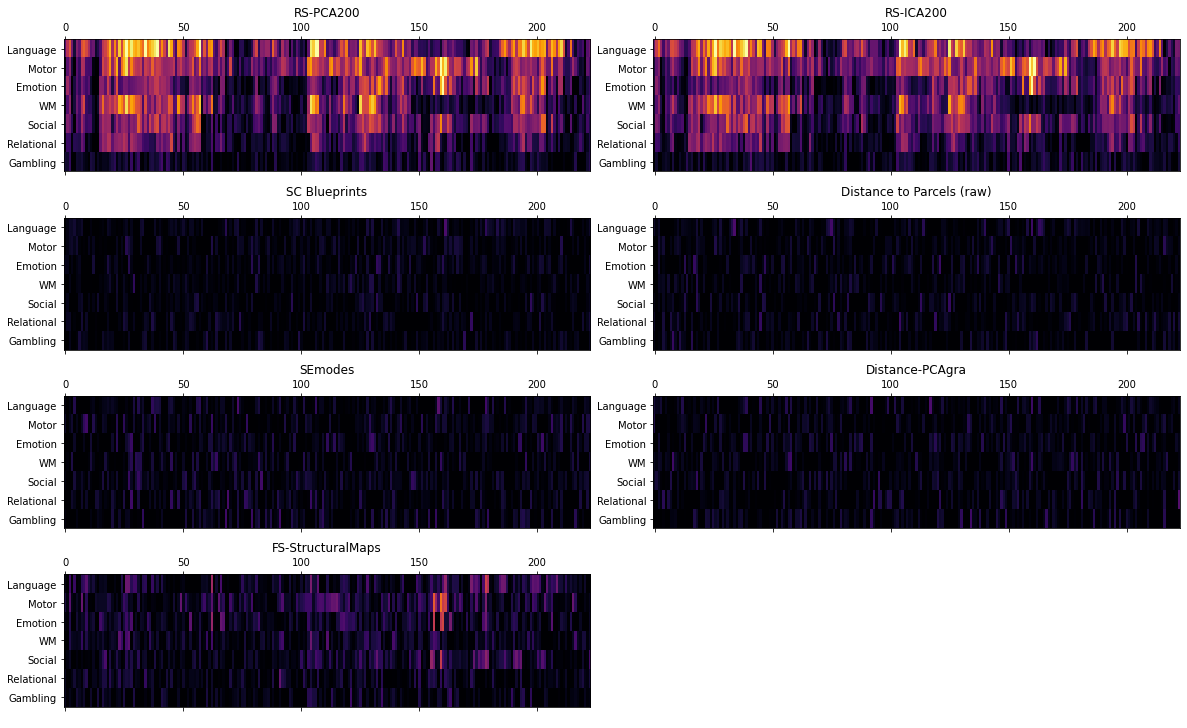

In [21]:
# plot per scores for the per parcel models

fig, axs = subplot_grid(4,2, cw=10, rh=3.2, flat_axes=1, axis_off=False)

for i, modality in enumerate(list(per_parcel_model_data.keys())):
    parcel_scores= per_parcel_model_data[modality]["parcel_scores"]
    im = axs[i].matshow(parcel_scores[:,1,contrast_ids_to_show].T, aspect=8, vmin=0, vmax=0.5, cmap="inferno"); 
    axs[i].set_yticklabels([""]+ task_names);
    axs[i].set_title(modality)

axs[-1].axis("off")
plt.subplots_adjust(wspace=0.12, hspace=0.11);

In [24]:
print(per_parcel_model_data.keys())
per_parcel_model_data['FS-StructuralMaps']["parcel_scores"][:,1,contrast_ids_to_show].max()

dict_keys(['RS-PCA200', 'RS-ICA200', 'SC Blueprints', 'Distance to Parcels (raw)', 'SEmodes', 'Distance-PCAgra', 'FS-StructuralMaps'])


0.3456038393697287

<ipython-input-25-28bfabd2c558>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([""]+ task_names);


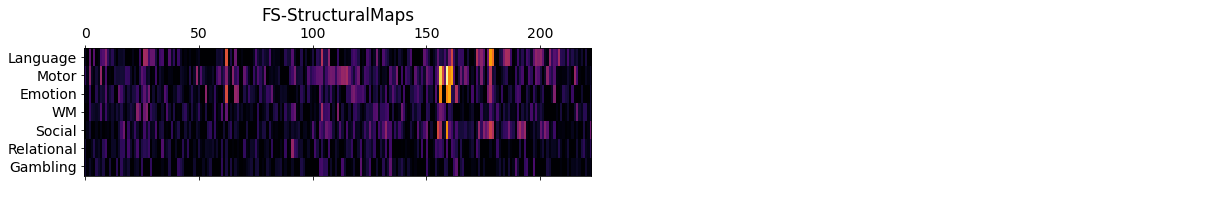

In [25]:
# plot per scores for the per parcel models
plt.rcParams.update({'font.size': 14})
fig, axs = subplot_grid(1,2, cw=10, rh=3.2, flat_axes=1, axis_off=False)
#axs = [plt.figure(figsize=(10,4)).gca()]
parcel_scores= per_parcel_model_data['FS-StructuralMaps']["parcel_scores"]
im = axs[0].matshow(parcel_scores[:,1,contrast_ids_to_show].T, vmin=0, vmax=0.35, aspect=8, cmap="inferno"); 
axs[0].set_yticklabels([""]+ task_names);
axs[0].set_title(modality)
axs[-1].axis("off");

#plt.colorbar(im, shrink=0.67);
#plt.subplots_adjust(wspace=0.12, hspace=0.11);

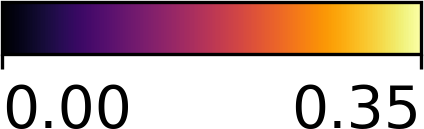

In [27]:
cb = infer_colorbar(None, cminmax=0, vmin=0,vmax=0.35, cmap="inferno", aspect=8, shrink=0.3, orientation="horizontal")
cb.set_ticks([0,0.35]); 
cb.ax.get_xticklabels()[0].set_horizontalalignment('left')  
cb.ax.get_xticklabels()[1].set_horizontalalignment('right')

#cb.ax.xaxis.set_tick_params(pad=10)  

cbimg = fig2tightPIL(cb.ax.get_figure(), dpi=300, format="png", close_fig=1)
cbimg

# Results for the FS-Structural Maps

In [28]:
modality = 'FS-StructuralMaps'

fn = "results/scores/within_parcel_models.lausanne.51test_subjs.47tasks.all_modalities.from_zscored.yfull.npy"
p = np.load(fn, allow_pickle=1).item()
parcellation29k = p["parcellation29k"]
parcel_id_to_label =  p["parcel_id_to_label"]
per_parcel_model_data  = p["within_parcel_scores_dict"][modality]
per_parcel_model_data.keys()


dict_keys(['parcel_scores', 'parcel_coeffs', 'parcel_intercepts'])

In [29]:
unique_contrasts2 = [uc.title().replace("_", " ") for uc in unique_contrasts]
plt.rcParams.update({'font.size': 16})

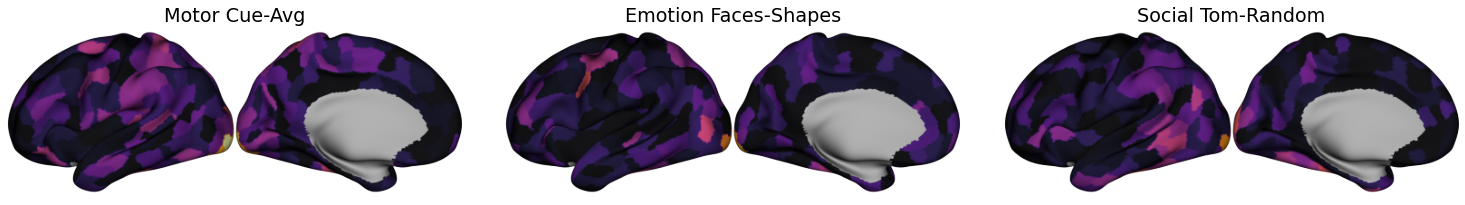

In [30]:
imgs = []
labels =[]

for tn in [16, 2, 27]: # 8,
    #group_map_thres = threshold_map(mean_task_maps[:, tn], percentile, binary=1, binary_val=1)
    m1 = map_to_labels(per_parcel_model_data['parcel_scores'][:, 1, tn], parcellation29k, mask=parcellation29k>1)
    #f = show_pdata(m1, cmap="inferno", cbar=None, color_range = (-0.04, 0.34))#, outline=group_map_thres, outline_cmap="cool");
    f = show_pdata(m1, cmap="inferno", cbar=None, color_range = (0, 0.35))#, outline=group_map_thres, outline_cmap="cool");
    #img = add_cbar(fig2pil(f, close=1), m1, uc=0.75, lc=0, cmap="inferno")
    img = fig2pil(f, close=1)
    imgs.append(img)
    labels.append(unique_contrasts2[tn])

fig, faxs = subplot_grid(1, 3, cw=7, flat_axes=True)

for i in range(3):
    faxs[i].imshow(imgs[i])
    faxs[i].set_title(labels[i]) #, size="xx-large")

plt.subplots_adjust(wspace=0.04, hspace=-0.1);
plt.tight_layout()

In [50]:
plt.close("all")

## Looking at the coeffecicients of the within parcel models

In [31]:
parcel_scores= per_parcel_model_data["parcel_scores"]
parcel_coeffs = per_parcel_model_data["parcel_coeffs"]
sorted_ids = np.argsort(parcel_scores[:,1,:], axis=0)[::-1,:]
plt.rcParams.update({'font.size': 10})

<ipython-input-33-838e37f22657>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([""]+ labels);


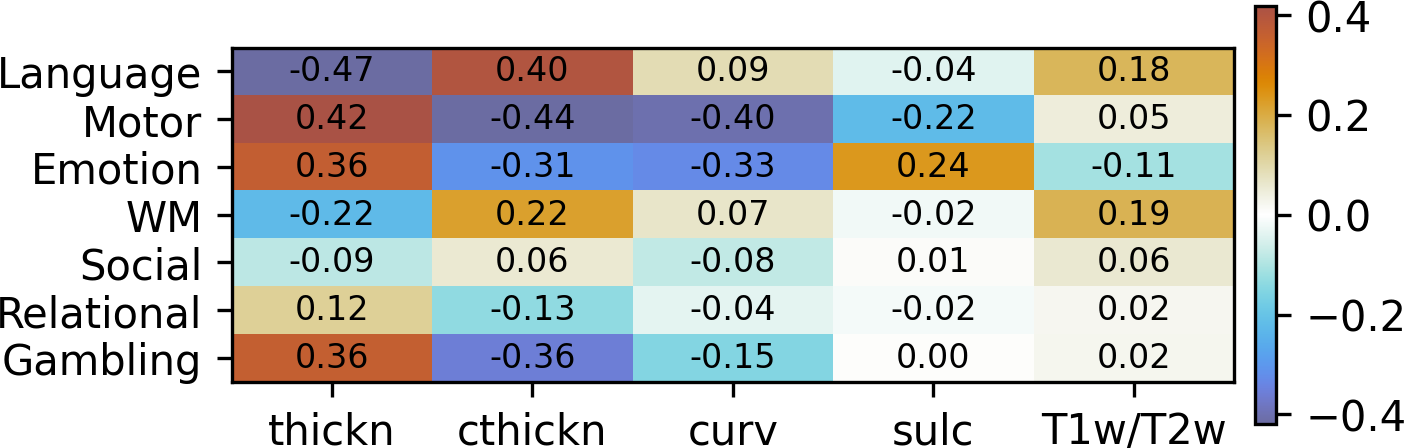

In [33]:
fig, axs = plt.subplots(1,1, figsize=(5,2)) 
#labels = ["myelin", "cthickn", "curv", "sulc", "thickn"]
labels = ["thickn", "cthickn", "curv", "sulc", "T1w/T2w"]
order = [4, 1,2,3, 0]

import cmasher as cmr
cmap_coeffs = "cmr.prinsenvlag_r" 

axs=[axs];

coeffs2show = []
for tn in contrast_ids_to_show:
    coeffs2show.append(parcel_coeffs[sorted_ids[:5,tn],tn, :].mean(axis=0))

    
coeffs2show=np.array(coeffs2show)[:, order]
best_coefficients = np.argsort(np.absolute(coeffs2show), axis=1)[:,::-1]

v = coeffs2show.flatten().max()

aspr=(coeffs2show.shape[1]/coeffs2show.shape[0])/3
im = axs[0].matshow(coeffs2show, cmap = cmap_coeffs, vmin=-v, vmax=v, aspect=aspr); 
for (i, j), z in np.ndenumerate(coeffs2show): 
  #if j in best_coefficients[i,:3]: plt.text(j, i, '{:.2f}'.format(z), ha='center', va='center', size=5)
  if j in best_coefficients[i,:5]: plt.text(j, i, '{:.2f}'.format(z), ha='center', va='center', size=8,)

plt.colorbar(im,fraction=0.020, pad=0.02, ax=axs[0]);#fxdcolorbar(im, ax=axs[0]);#plt.colorbar(im, ax=axs[0]);
axs[0].set_yticks(np.arange(len(task_names))); axs[0].set_yticklabels( task_names);
axs[0].set_xticklabels([""]+ labels);
#axs[0].set_xlabel(f"Average weights (across 5 most discriminable parcels) of structural maps", loc="right"); 
axs[0].xaxis.set_label_position('top') 
axs[0].xaxis.set_ticks_position('bottom') 
plt.tight_layout()

weights_img = fig2tightPIL(fig, dpi=300, format="png", close_fig=1)
weights_img



## Individual predictions 
stiched together from parcel-wise models

In [44]:
def get_best_differentiated_subj_ids(y_test_pred, y_test, v=False):
  n_subjs= y_test.shape[0]; 
  n_tasks = y_test.shape[2]; 
  
  # dd indxes how well each subject is differentiated from all others on a per task basis
  dd = np.zeros((n_tasks, n_subjs))
  
  for tn in range(n_tasks): 
    corr_mat = np.corrcoef(y_test[:,:,tn],y_test_pred[:,:, tn])
    corr_mat = corr_mat[:n_subjs,n_subjs:]
    #plt.matshow(corr_mat)
  
    diagonal_corrs = np.diag(corr_mat);
    corr_tmp=corr_mat.copy()
    np.fill_diagonal(corr_tmp, np.nan)
    avg_cross_corrs = np.nanmean(corr_tmp,axis=0); 
    dd[tn, :] = (diagonal_corrs- avg_cross_corrs)

  best = np.argsort(dd, axis=1)[:, ::-1]
  best_across_tasks = np.argsort(dd.mean(axis=0))[::-1]
  if v: print("Best 10 differentiated subjects across tasks:", best_across_tasks[:10])
  return dd, best, best_across_tasks

In [45]:
# probably from F-structural measures

fn = "results/scores/within_parcel_models.lausanne.51test_subjs.47tasks.pca_with_real_and_pred_maps.from_zscored.yfull.npy"
p = np.load(fn, allow_pickle=1).item()
parcellation29k = p["parcellation29k"]
y_test, y_test_pred= p["y_test"], p["y_test_pred"]
subjs=p["test_subjs"]
_, best, best_across_tasks = get_best_differentiated_subj_ids(y_test, y_test_pred, v=1)


Best 10 differentiated subjects across tasks: [30 20 46 21 25 28 39 45 33 49]


In [46]:
from lib.linear_models import score
scoresd, diff_scores_test = score(y_test_pred, y_test);
diff_scores_test[contrast_ids_to_show]

array([0.006739  , 0.01646269, 0.01445786, 0.00817772, 0.01117333,
       0.00592324, 0.00417996])

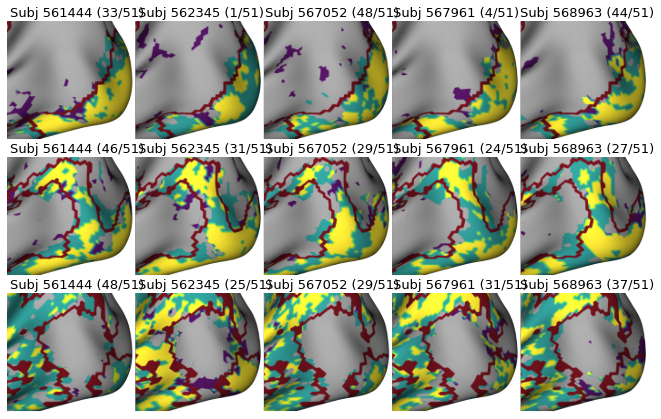

In [47]:
fig, axs = subplot_grid(3, 1, cw=2.3*5, rh=2.5, flat_axes=1)

shape = (335, 150, 475, 280)
for i, tn in enumerate([16, 2, 27]):
  imgs= []
  headings= []
  group_map_thres = threshold_map(mean_task_maps[:, tn], percentile, binary=1, binary_val=1)


  for k in range(5):
    sn = k# index_in_big[::-1][k]
    #rtsn = index_in_rts[::-1][k]

    real_map_thres = threshold_map(y_test[sn, :, tn], percentile, binary=1, binary_val=1)
    pred_map_thres = threshold_map(y_test_pred[sn, :, tn], percentile, binary=1, binary_val=1)
    combined_map = real_map_thres + (pred_map_thres*2)
    f = show_pdata(combined_map, cmap="viridis", cbar=None, outline=group_map_thres, plot_kwargs =dict(size=(1600, 600)))
    img = fig2pil(f, close=1);
    im = img.crop(shape)
    imgs.append(im);
    
    n =list(best[tn]).index(sn) +1 
    headings.append(f"Subj {subjs[sn]} ({n}/{len(best[tn])})")

  axs[i].imshow(image_grid(imgs, 1, 5, size=(140,130)))
  for k in range(5):
    axs[i].text(140*(k)+3, -5, headings[k], horizontalalignment="left", size=13)

  #title=unique_contrasts[tn].replace("_", ":\n").lower().title()
  #t = axs[i].set_title(title, loc="left",  x=0.0, y=0.775)
  #t.set_bbox(dict(facecolor='white', alpha=0.8, lw=0.3))

plt.subplots_adjust(wspace=0.01, hspace=0);
#plt.tight_layout(pad=0.3)


In [45]:
plt.close("all")